In [1]:
import re
import string
import pandas as pd
from math import log
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import numpy
from sklearn.decomposition import LatentDirichletAllocation


### Collecting dataset - 3 news grops from 20newsgroups:

In [2]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

c:\users\alex\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Preprocessing and vectorizing:

In [3]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

In [4]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing, stop_words="english", max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data, newsgroups_train.target)
print(tfidf.shape)

bag_of_words_vectorizer = CountVectorizer(preprocessor=preprocessing, stop_words="english", max_df=0.95, min_df=2,)
bag_of_words = bag_of_words_vectorizer.fit_transform(newsgroups_train.data, newsgroups_train.target)
print(bag_of_words.shape)

(1657, 14729)
(1657, 14729)


### Vizualizing:

In [5]:
def show(figure, model, X, Y):
    plt.figure(0, figsize=(20,10))
    def calculate(X, n):
        reduced_features = model.fit_transform(X.toarray())
        plt.subplot(1, 2, n)
        plt.title(['', 'Tfidf + ', 'Bag of words + '][n] + ['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=newsgroups_train.target)
    calculate(X, 1)
    calculate(Y, 2)

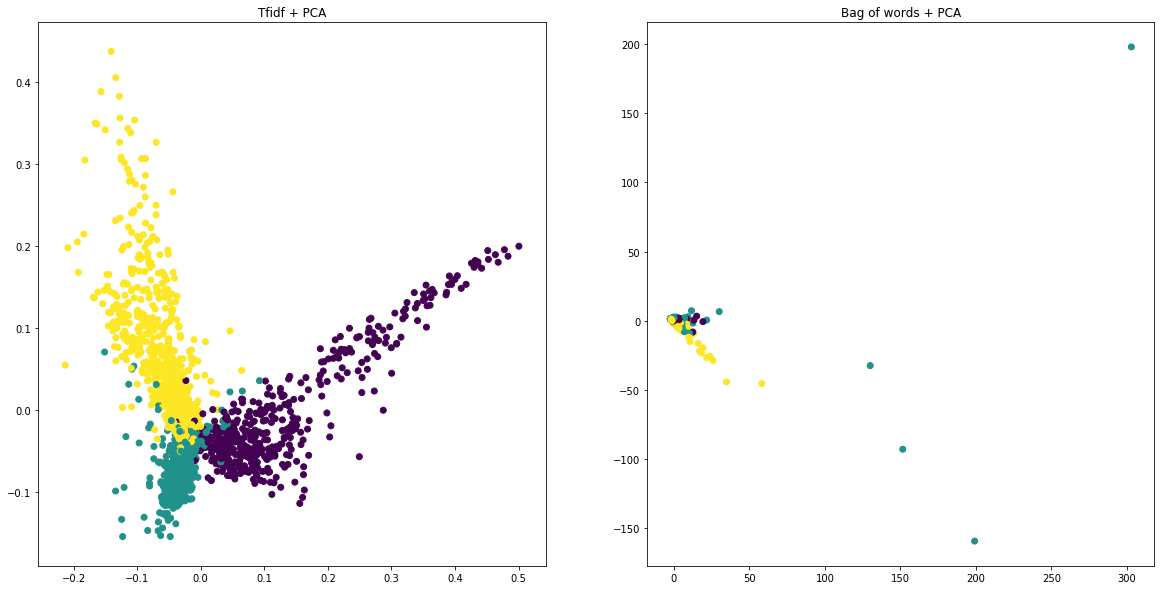

In [6]:
show(0, PCA(n_components=2, random_state=42), tfidf, bag_of_words)

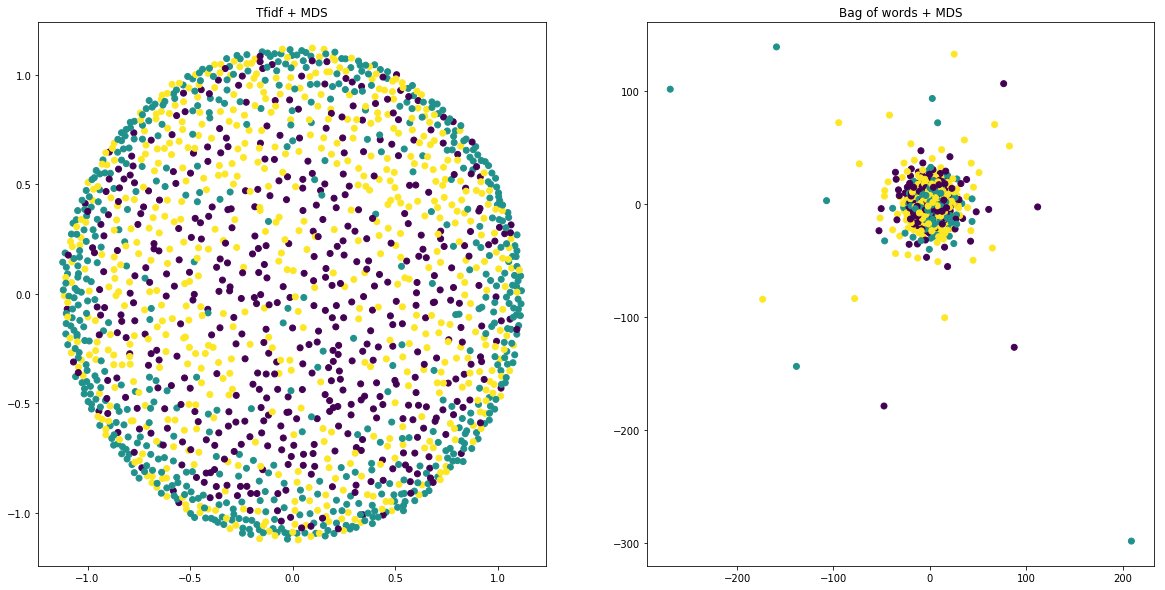

In [7]:
show(1, MDS(n_components=2, random_state=42), tfidf, bag_of_words)

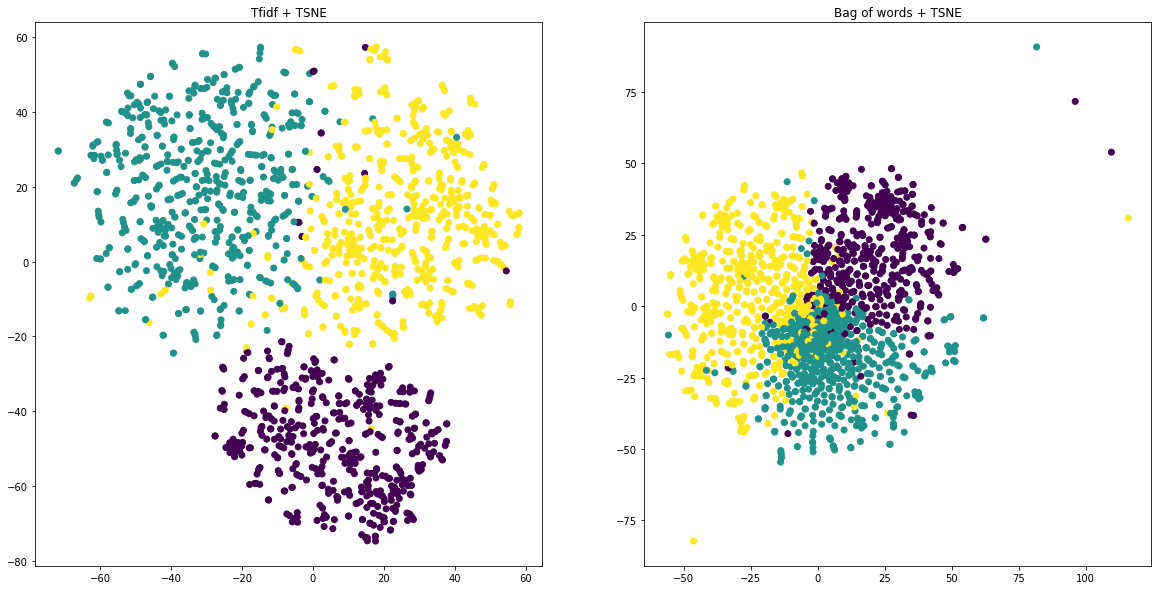

In [8]:
show(2, TSNE(n_components=2, random_state=42), tfidf, bag_of_words)

In [9]:
def find_clusters_number(model, X, r=range(1, 7)):
    scores = {}
    for n in r:
        model.set_params(n_clusters=n)
        predicted = model.fit_predict(X.todense())
        scores[metrics.accuracy_score(newsgroups_train['target'], predicted)] = n
    print(scores)
    print(f'\nBest accuracy score for this model - {max(scores.keys())}\nNumber of clusters - {scores[max(scores.keys())]}')
    return scores[max(scores.keys())]

## Agglomerative Clustering:

In [10]:
aglom_predicted = []
for X in [tfidf, bag_of_words]:
    n_clusters = find_clusters_number(AgglomerativeClustering(memory="mycachedir"), X)
    aglom = AgglomerativeClustering(n_clusters=n_clusters, memory="mycachedir")
    aglom_predicted.append(aglom.fit_predict(X.todense()))

{0.28968014484007243: 1, 0.024140012070006035: 2, 0.35787567893783945: 3, 0.3204586602293301: 4, 0.08569704284852142: 6}

Best accuracy score for this model - 0.35787567893783945
Number of clusters - 3
{0.28968014484007243: 1, 0.3500301750150875: 2, 0.29149064574532285: 3, 0.0: 4, 0.003621001810500905: 5, 0.0012070006035003018: 6}

Best accuracy score for this model - 0.3500301750150875
Number of clusters - 2


In [11]:
def show_predicted(figure, decomp, predicted, X, Y):
    plt.figure(0, figsize=(20,10))
    def calculate(X, n):
        reduced_features = decomp.fit_transform(X.toarray())
        plt.subplot(1, 2, n)
        plt.title(['', 'Tfidf + ', 'Bag of words + '][n] + ['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=predicted[n-1])
    calculate(X, 1)
    calculate(Y, 2)

### Vizualizing:

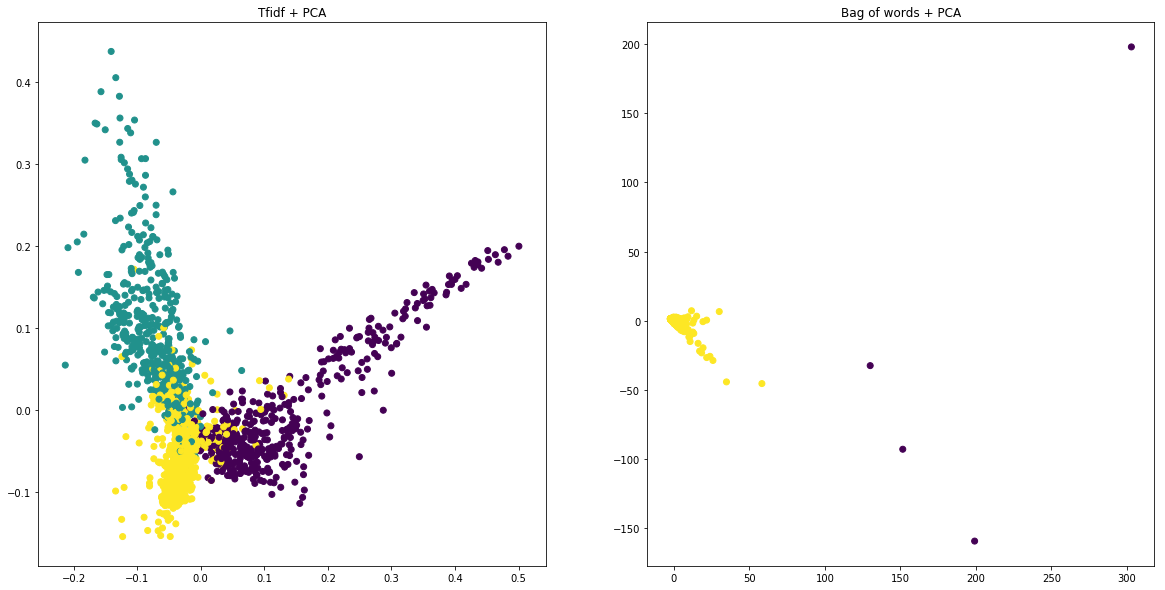

In [12]:
show_predicted(0, PCA(n_components=2, random_state=42), aglom_predicted, tfidf, bag_of_words)

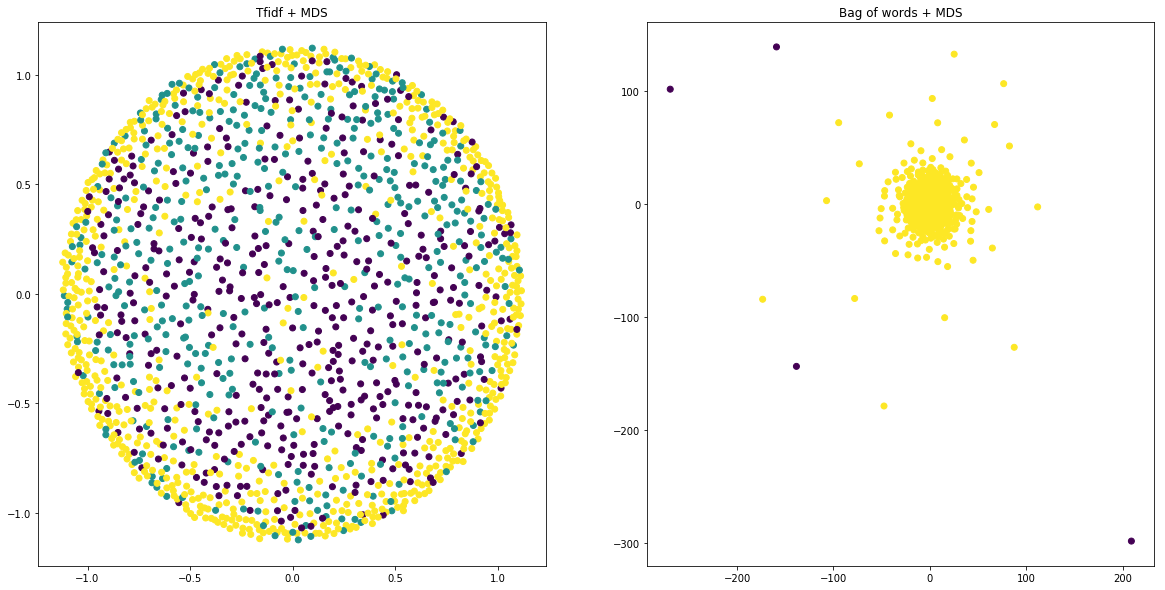

In [13]:
show_predicted(1, MDS(n_components=2, random_state=42), aglom_predicted, tfidf, bag_of_words)

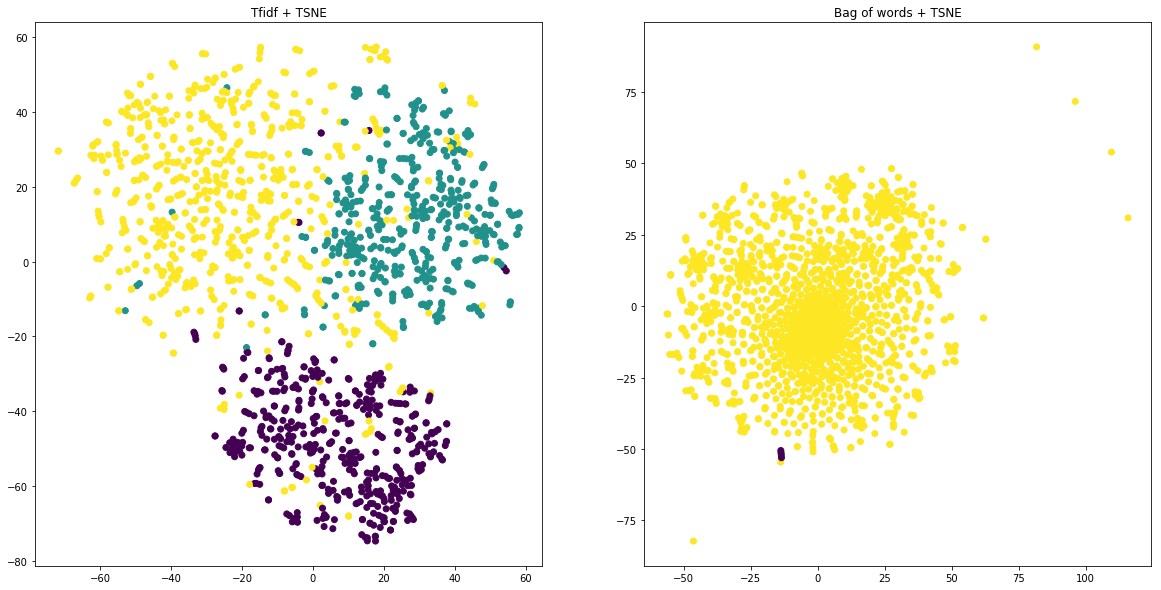

In [14]:
show_predicted(2, TSNE(n_components=2, random_state=42), aglom_predicted, tfidf, bag_of_words)

## DBSCAN:

In [15]:
dbscan = DBSCAN(eps=0.9, min_samples=10)
dbscan_fit = dbscan.fit(tfidf.todense())
dbscan_predicted = dbscan.fit_predict(tfidf.todense())
print(metrics.accuracy_score(newsgroups_train['target'], dbscan_predicted))

0.0


In [19]:
dbscan_predicted = [dbscan_predicted, dbscan.fit_predict(bag_of_words.todense())]

### Vizualizing:

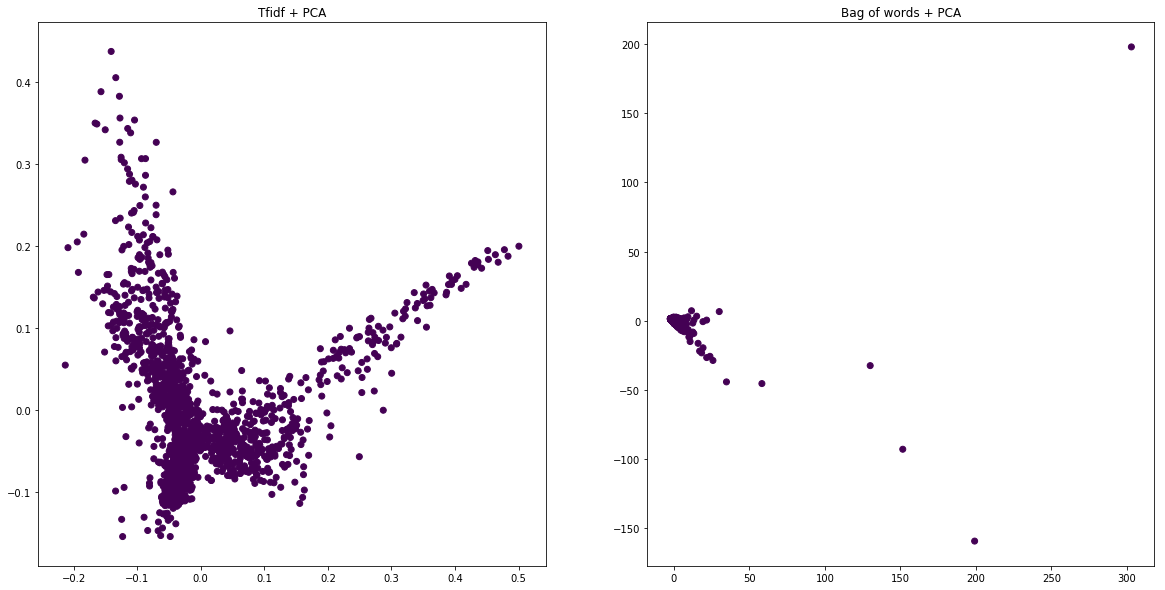

In [20]:
show_predicted(0, PCA(n_components=2, random_state=42), dbscan_predicted, tfidf, bag_of_words)

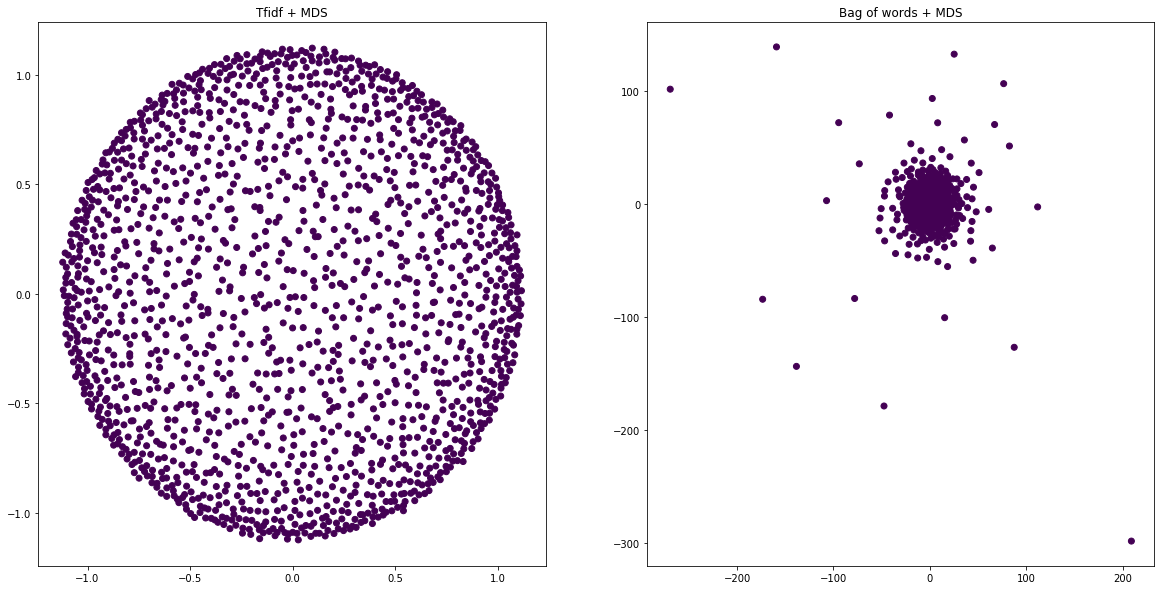

In [21]:
show_predicted(1, MDS(n_components=2, random_state=42), dbscan_predicted, tfidf, bag_of_words)

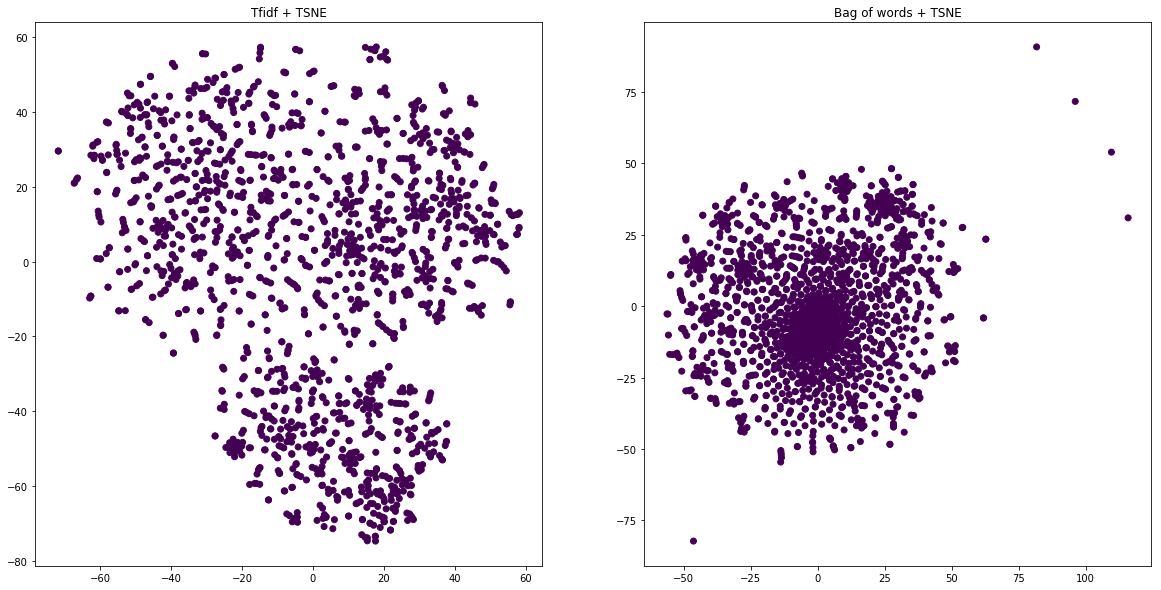

In [22]:
show_predicted(2, TSNE(n_components=2, random_state=42), dbscan_predicted, tfidf, bag_of_words)

## K-Means:

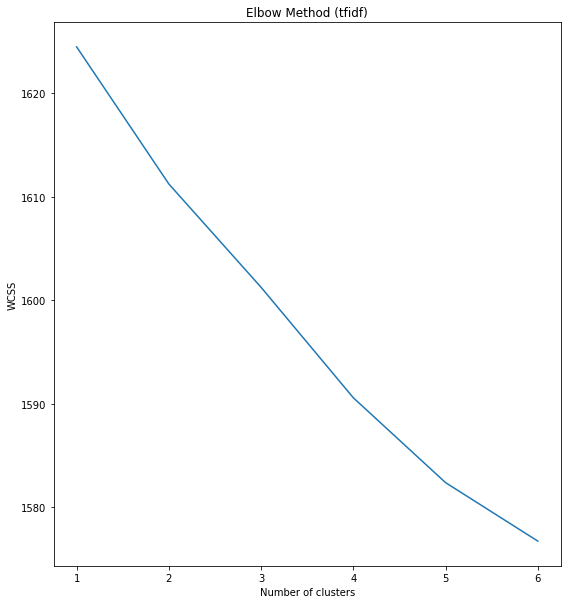

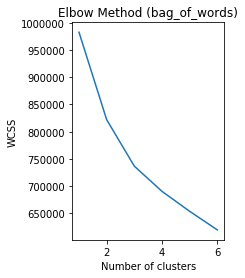

In [23]:
def elbow(tfidf, bag_of_words):
    plt.figure(0, figsize=(20,10))
    def calculate(n, X):
        wcss = []
        for n_clusters in range(1, 7):
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
        plt.subplot(1, 2, n)
        plt.plot(range(1, 7), wcss)
        plt.title(f'Elbow Method ({["tfidf", "bag_of_words"][n-1]})')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
    calculate(1, tfidf)
    calculate(2, bag_of_words)

elbow(tfidf, bag_of_words)

In [24]:
kmeans_predicted = []
for X in [tfidf, bag_of_words]:
    n_clusters = find_clusters_number(KMeans(), X)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans_predicted.append(kmeans.fit_predict(X.todense()))

{0.28968014484007243: 1, 0.026554013277006638: 2, 0.08026554013277007: 3, 0.292094146047073: 4, 0.108026554013277: 5, 0.34821967410983706: 6}

Best accuracy score for this model - 0.34821967410983706
Number of clusters - 6
{0.28968014484007243: 1, 0.292094146047073: 2, 0.29149064574532285: 3, 0.29631864815932407: 4, 0.35184067592033796: 5, 0.28907664453832227: 6}

Best accuracy score for this model - 0.35184067592033796
Number of clusters - 5


### Vizualizing:

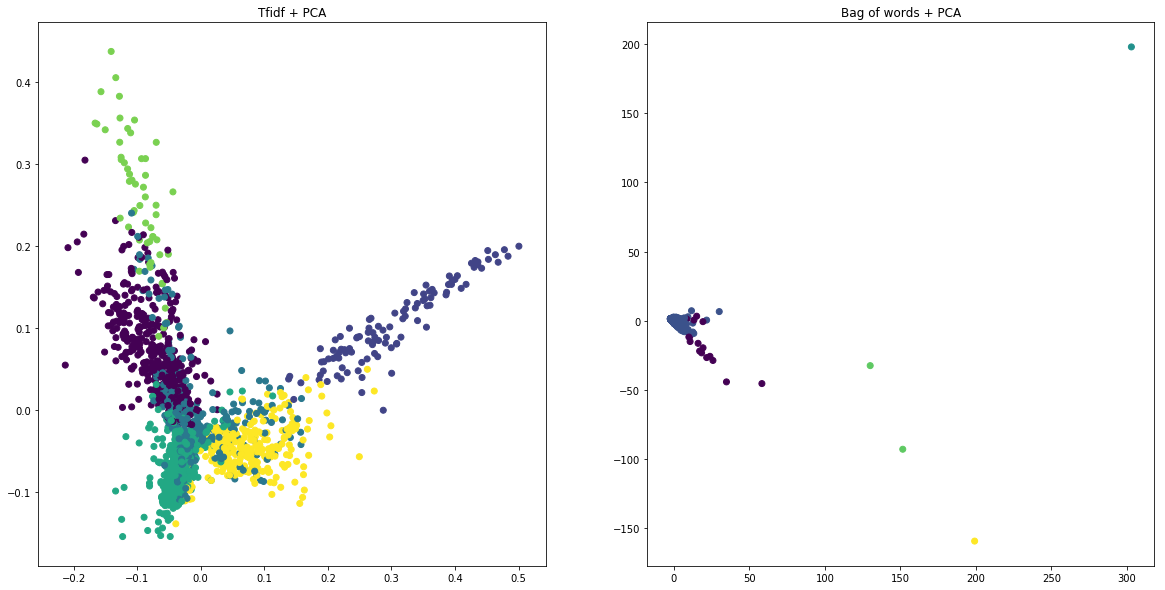

In [25]:
show_predicted(0, PCA(n_components=2, random_state=42), kmeans_predicted, tfidf, bag_of_words)

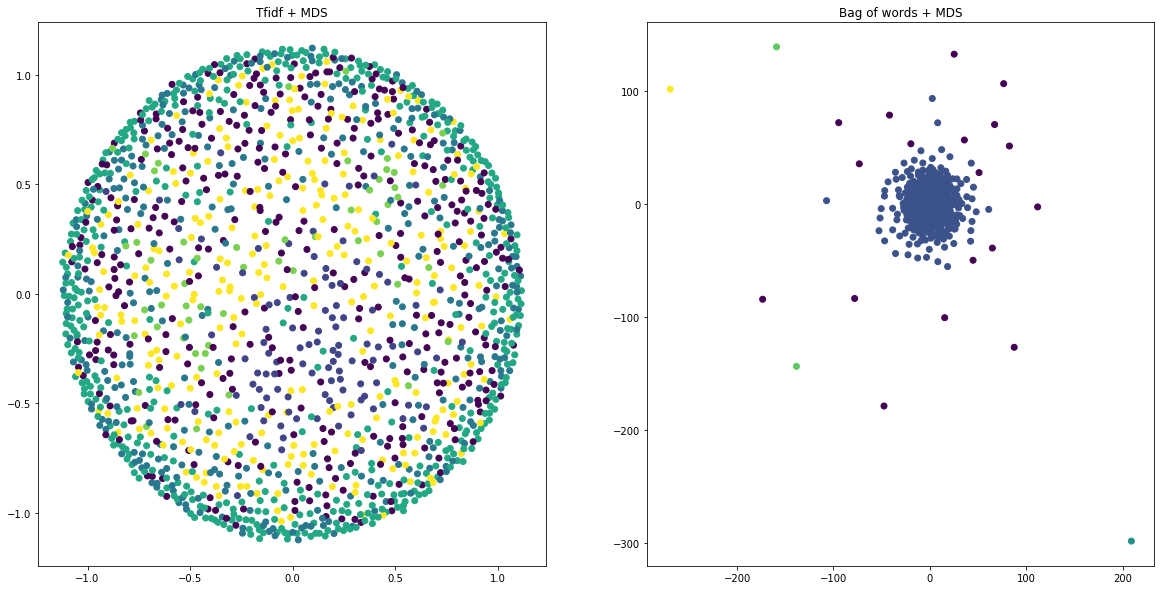

In [26]:
show_predicted(1, MDS(n_components=2, random_state=42), kmeans_predicted, tfidf, bag_of_words)

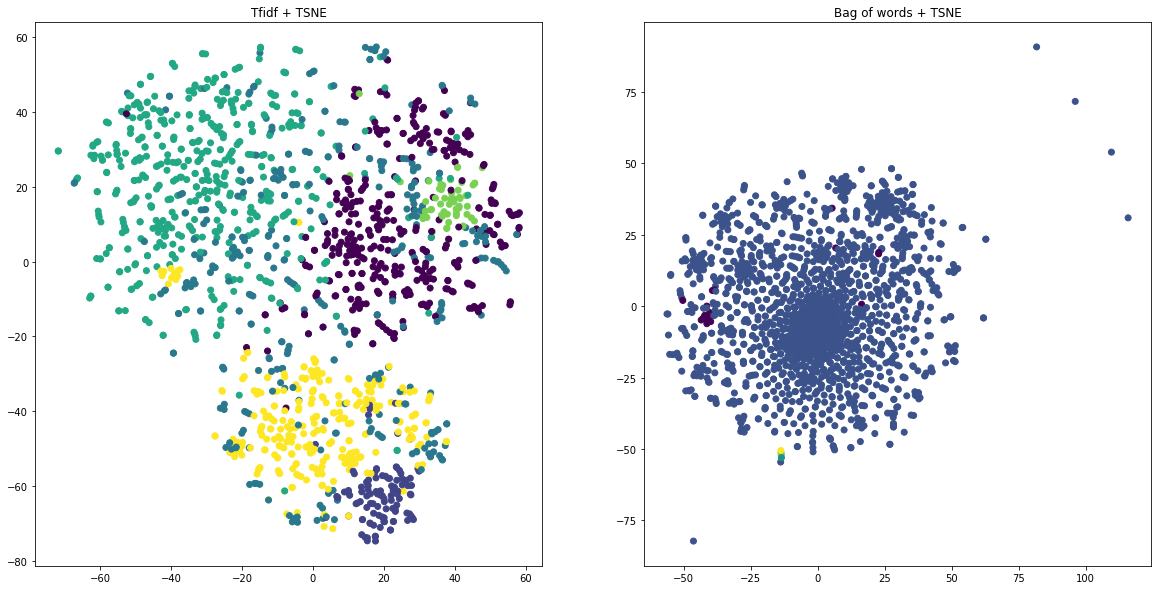

In [27]:
show_predicted(2, TSNE(n_components=2, random_state=42), kmeans_predicted, tfidf, bag_of_words)

## Latent Dirichlet Allocation:

In [28]:
lda = LatentDirichletAllocation(n_components=3, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)
lda.fit(bag_of_words)

tf_feature_names = bag_of_words_vectorizer.get_feature_names()

In [29]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tf_feature_names, 10)

Topic #0: edu god writes just don people think article com posting
Topic #1: com edu writes article people don islam like posting think
Topic #2: edu space nasa graphics image university data com gov program

